<a href="https://colab.research.google.com/github/BitKnitting/HAR_LSTM_COLAB/blob/master/HAR_LSTM_FirstAttempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
My goal is to understand how to input samples of people doing things like walking and falling (Human Activity) then use LSTM Deep Learning in Keras to figure out future samples.

## Thanks to Those that Went Before

### Datasets
From my Googly research, there are two popular datasets for human activity:  
-  [‘Activity Recognition Using Smart Phones Dataset’](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) available as [one of the UCI datasets](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/)
- [The WISDM dataset](http://www.cis.fordham.edu/wisdm/dataset.php) available by going to the downloads link.  

### Articles
- [How to Develop RNN Models for Human Activity Recognition Time Series Classification](https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/) uses the UCI dataset.
- [Human Activity Recognition (HAR) Tutorial with Keras and Core ML (Part 1)](https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0)  uses the WISDM dataset.  
- [Human Activity Recognition using LSTMs on Android — TensorFlow for Hackers (Part VI)](https://medium.com/@curiousily/human-activity-recognition-using-lstms-on-android-tensorflow-for-hackers-part-vi-492da5adef64) uses the WISDM dataset.  
_NOTE: The last article appears to be a write up of [the YouTube video, Recognize real time human activity using LSTM (Long Short Term Memory-Deep Learning)](https://www.youtube.com/watch?v=RcYjYw4FN2A&t=654s)

## Dataset
The datasets seem very similar in what they provide.  I'll be (somewhat arbitrarily) using the WISDM dataset.
  


# Load Data
- [Downloaded file](http://www.cis.fordham.edu/wisdm/dataset.php)
- Unzipped and copied the folder onto my Google Drive.
- Mounted Google Drive.  
- Read the data into numpy arrays.



In [2]:
#
# Mount Google Drive.
#
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Data oops in WISDM Data?
Wha?  There is a semicolon at the end of each row...I'll use sed to remove it (using....'hey sed, when you see a ; remove it...')

In [3]:
! head -5 '/content/drive/My Drive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [0]:

!sed 's/;//' '/content/drive/My Drive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'  > '/content/drive/My Drive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.nosemi'

In [19]:
! head -5 '/content/drive/My Drive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.nosemi'

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
33,Jogging,49106062271000,5.012288,11.264028,0.95342433
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


## Back to loading data
Now we can talk data loading..notice I'm loading the nosemi file....

In [20]:
#
# Load Data into a Pandas DataFrame.
#
# TODO: The z-axis comes in as an object = note the semicolon as the end.  Hmmm....
import pandas as pd
columns = ['user','activity','timestamp','x-axis','y-axis','z-axis']
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.nosemi',header=None,names=columns,sep=',')
df.dropna()
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


# Explore
So what's in this dataset?
## Rows and Columns
There are 1,098,204 accelerometer measurements.  Along with the x,y,z axis columns, there are columns that specify which user was wearing the accelerometer when the measurement occurred.  What activity the user was doing, and the a timestamp that identifies where the measurement is within the time series.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
user         1098204 non-null int64
activity     1098204 non-null object
timestamp    1098204 non-null int64
x-axis       1098204 non-null float64
y-axis       1098204 non-null float64
z-axis       1098203 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


## Number of Readings by Activity
A large chunk of the measurements are done for users walking.  There are far fewer measurements for folks standing.

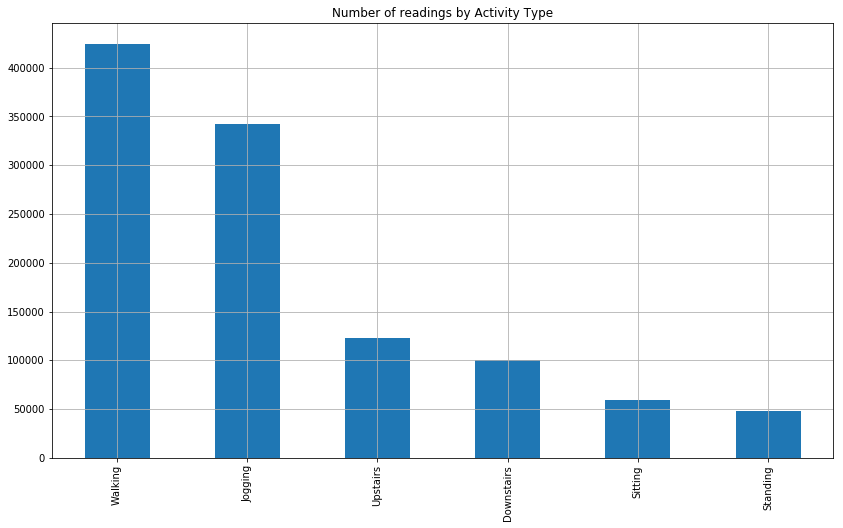

In [32]:
countOfActivities = df['activity'].value_counts()
countOfActivities.plot(kind='bar',title='Number of readings by Activity Type',figsize=(14,8),grid=True);